In [136]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt
import sys

# Import encryption libraries
import tenseal as ts


## Data Preprocessing:

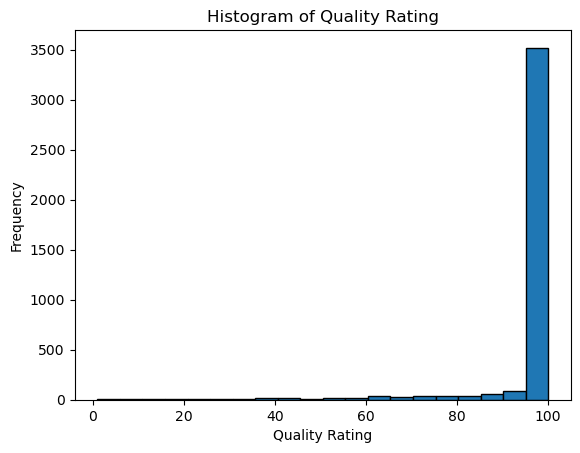

Correlation coefficients with Quality Rating:
Pressure (kPa)                    0.013129
Temperature x Pressure           -0.258474
Temperature (°C)                 -0.461279
Material Fusion Metric           -0.511972
Material Transformation Metric   -0.575756
Name: Quality Rating, dtype: float64


In [137]:
# Step 1: Data Preprocessing
preprocessing_start = time.time()
# Load the dataset
data = pd.read_csv("../datasets/manufacturing.csv")

# Handle missing values if any
data.fillna(0, inplace=True)

# Check for data imbalance
plt.hist(data['Quality Rating'], bins=20, edgecolor='black')
plt.title('Histogram of Quality Rating')
plt.xlabel('Quality Rating')
plt.ylabel('Frequency')
plt.show()

# Analyse correlations with QualityRating
corr_matrix = data.corr()
target_corr = corr_matrix['Quality Rating'].drop('Quality Rating')  # Exclude the target itself
print("Correlation coefficients with Quality Rating:")
print(target_corr.sort_values(ascending=False))

preprocessing_time = time.time() - preprocessing_start


        1  Temperature (°C)  Pressure (kPa)  Temperature x Pressure  \
0     1.0          0.111043       -0.674347               -0.464381   
1     1.0          0.442155        0.097399                0.546578   
2     1.0          0.218411       -0.695002               -0.445114   
3     1.0          0.103221        0.890306                1.075862   
4     1.0         -0.138040        0.095981                0.112665   
...   ...               ...             ...                     ...   
3952  1.0         -0.415858        0.692249                0.346966   
3953  1.0         -0.007493       -0.650398               -0.487026   
3954  1.0          0.425431        0.155056                0.599784   
3955  1.0          0.103854        0.892677                1.078912   
3956  1.0         -0.350697        0.944602                0.608510   

      Material Fusion Metric  Material Transformation Metric  \
0                  -0.002221                        0.112155   
1                  

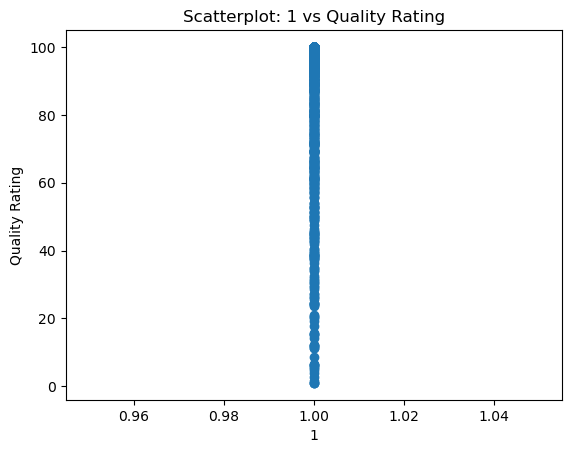

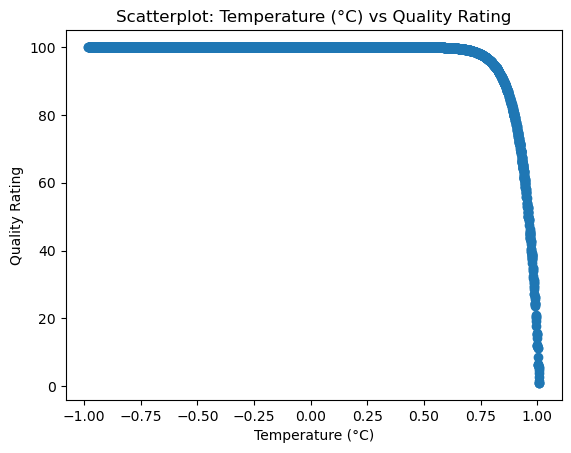

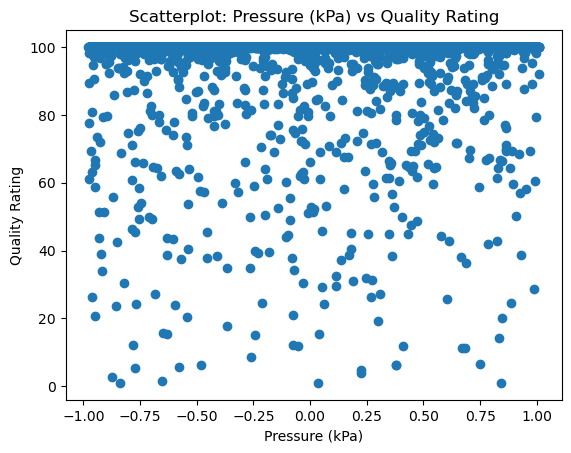

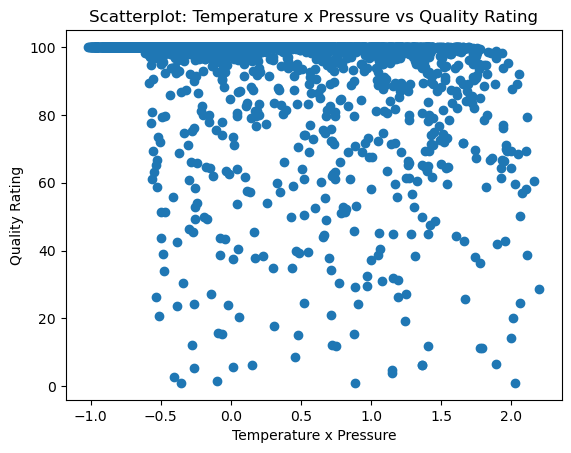

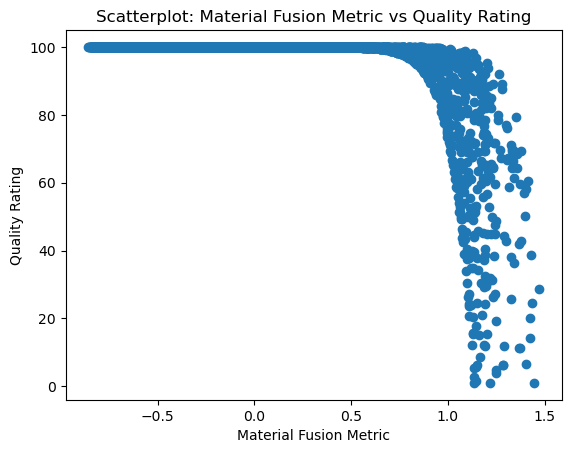

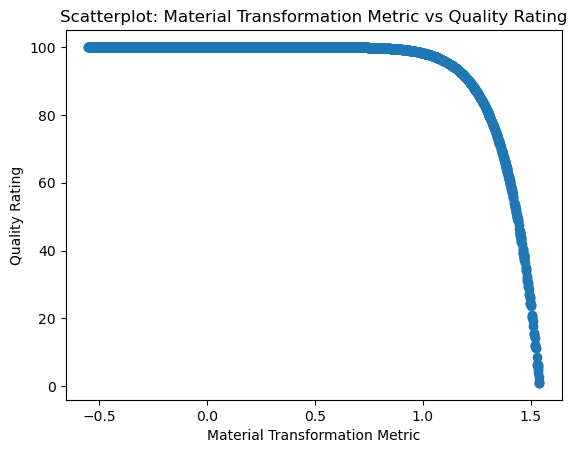

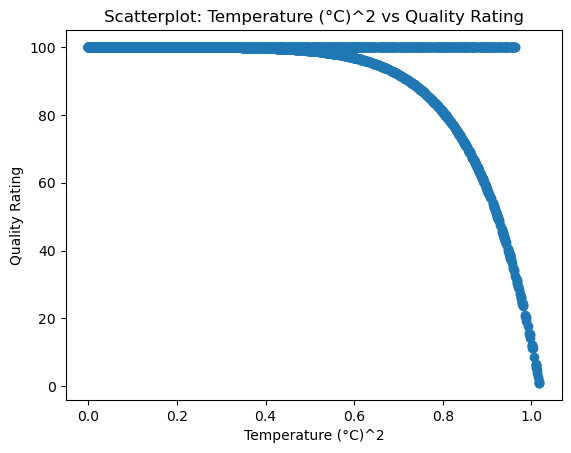

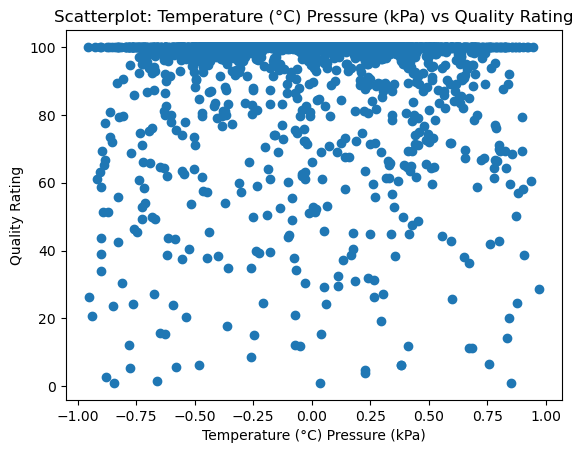

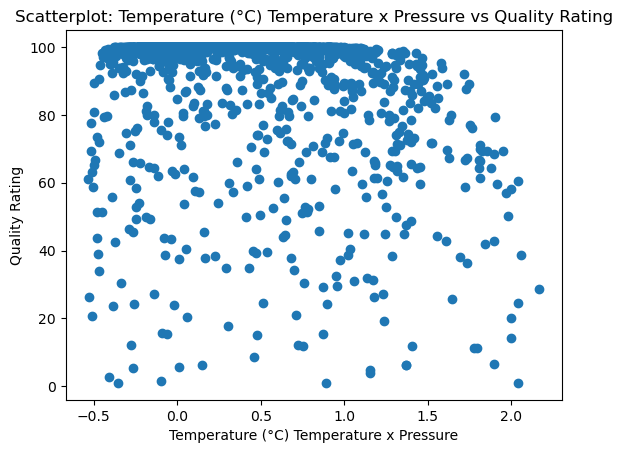

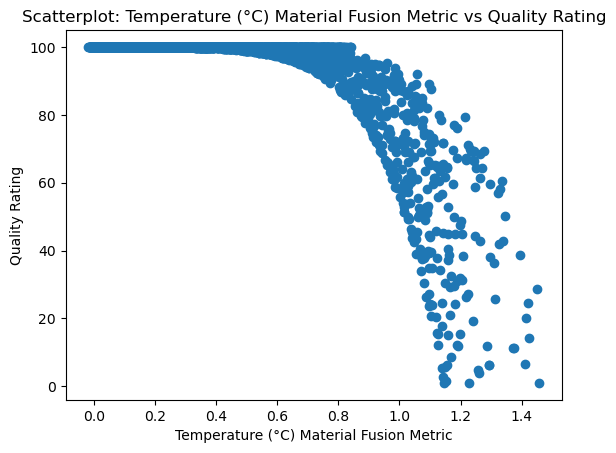

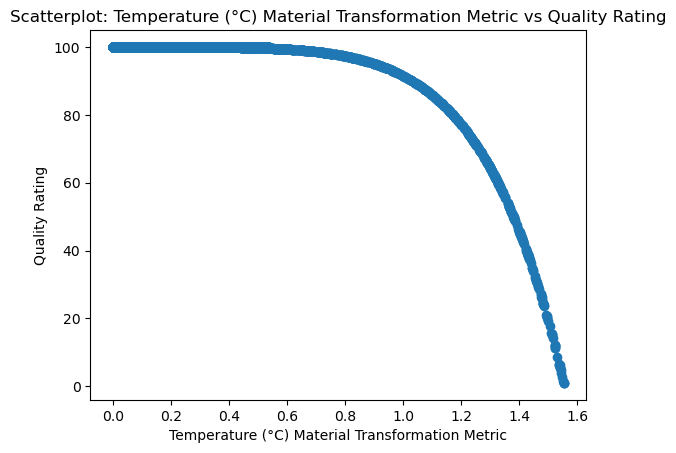

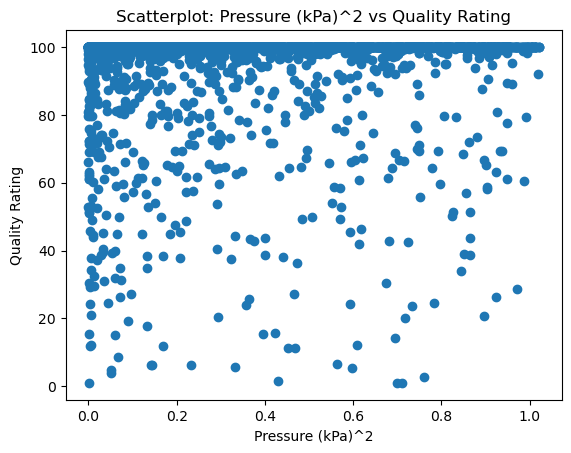

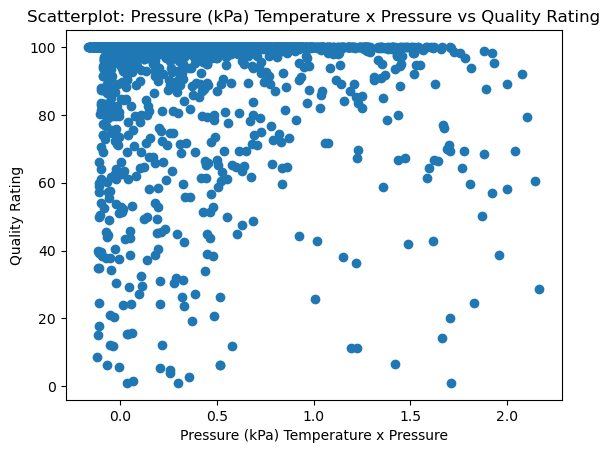

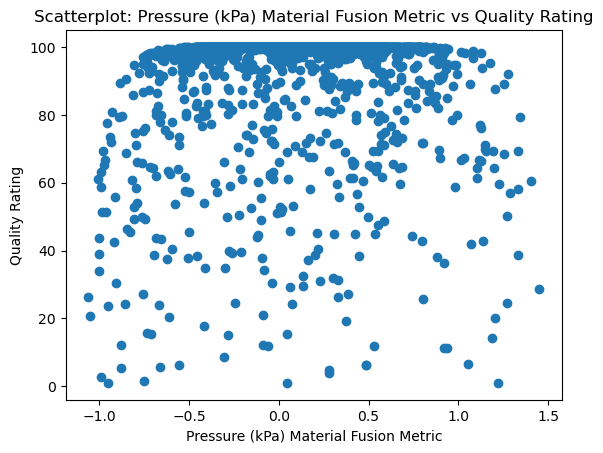

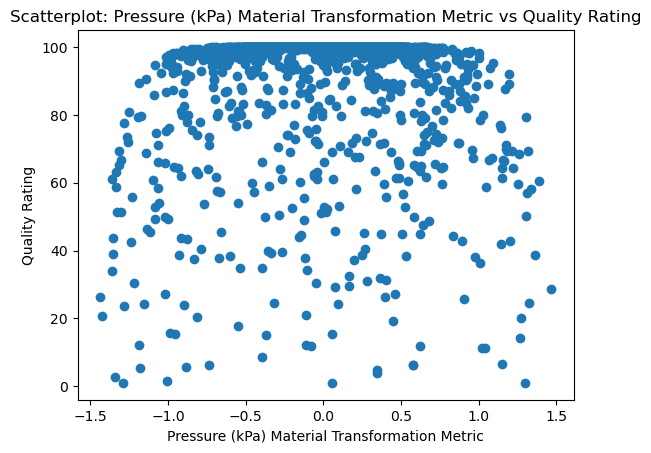

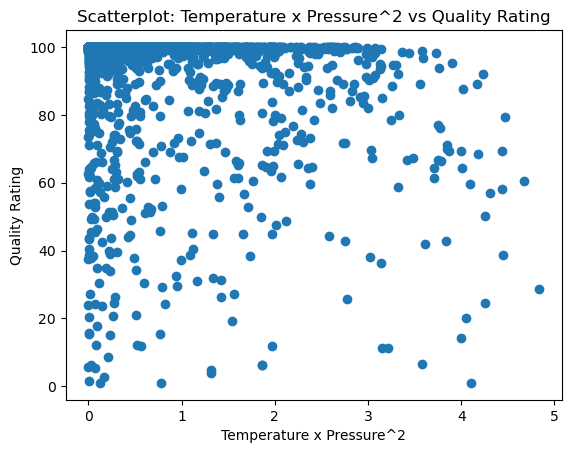

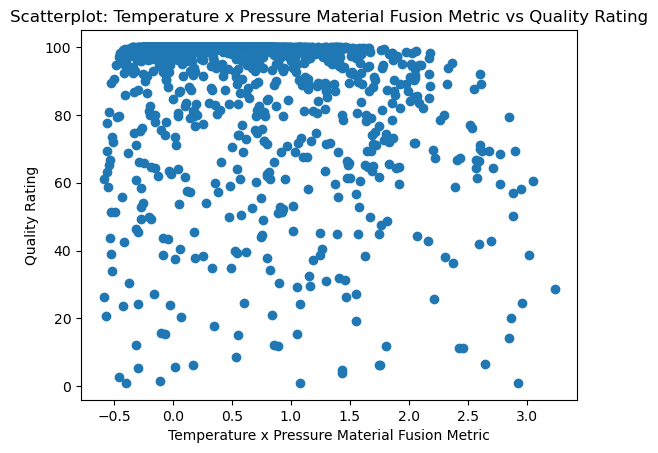

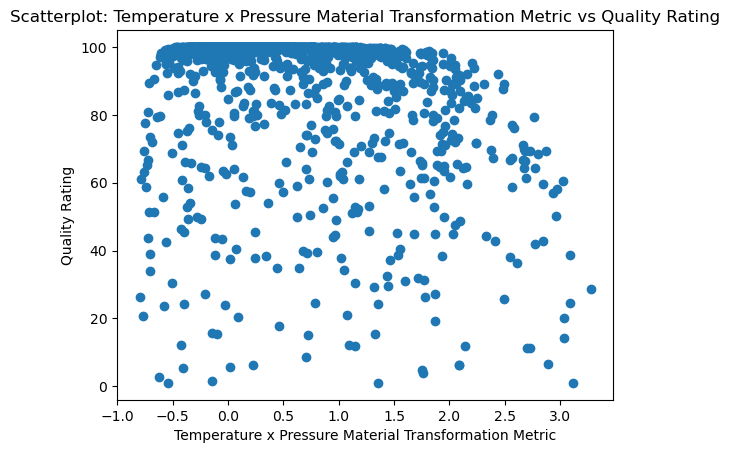

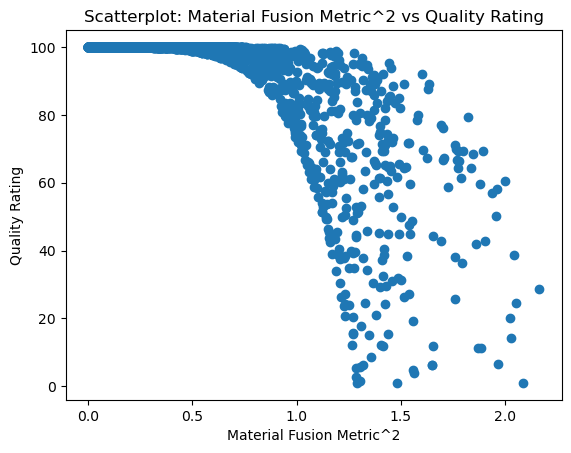

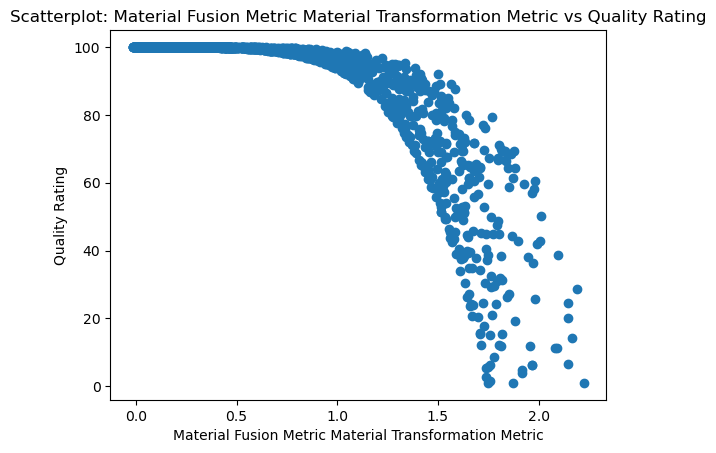

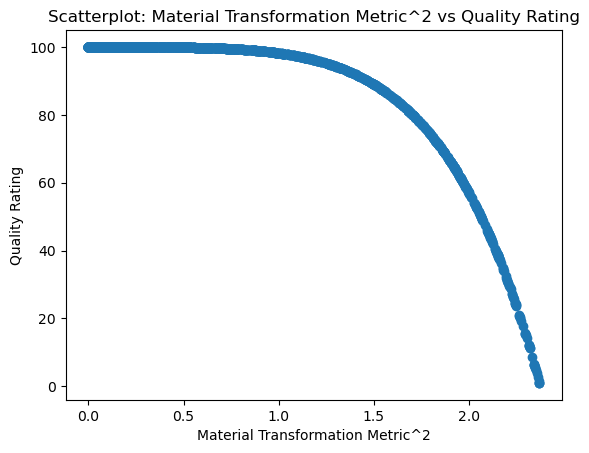

In [138]:
# Step 2: Feature Selection
feature_selection_start = time.time()
X = data.drop(['Quality Rating'], axis=1)
y = data['Quality Rating']

# Scale X
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Generate polynomial features
degree = 2
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_scaled)

# Convert X_poly to DataFrame with feature names
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

print(X_poly_df)
for feature in X_poly_df.columns:
    plt.scatter(X_poly_df[feature], y)
    plt.title(f"Scatterplot: {feature} vs Quality Rating")
    plt.xlabel(feature)
    plt.ylabel("Quality Rating")
    plt.show()

feature_selection_time = time.time() - feature_selection_start


## Plaintext Model

In [139]:
# Step 3: Model Selection and Training
plaintext_train_start = time.time()

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
plaintext_train_time = time.time() - plaintext_train_start


Performance Metrics (Plaintext model):
Mean Absolute Error: 2.4734999976371785
Mean Squared Error: 15.027666515264524
Root Mean Squared Error: 3.8765534325305673
R^2 Score: 0.9263893126590724

Runtime Analysis (Plaintext model):
Required Preprocessing time: 3.950904369354248
Training runtime: 0.0040 seconds
Evaluation runtime: 0.0010 seconds
Total runtime without preprocessing: 0.0050 seconds
Total runtime: 3.9559 seconds

Memory Usage (Plaintext model):
Memory Usage for Coefficients: 0.16 KB
Memory Usage for Intercept: 0.03 KB
Memory Usage for Features: 129.94 KB


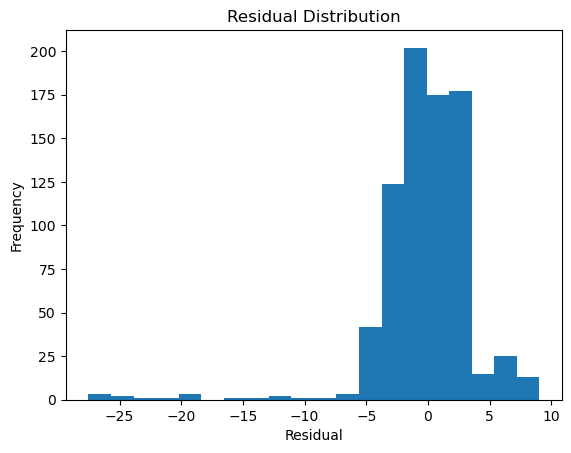

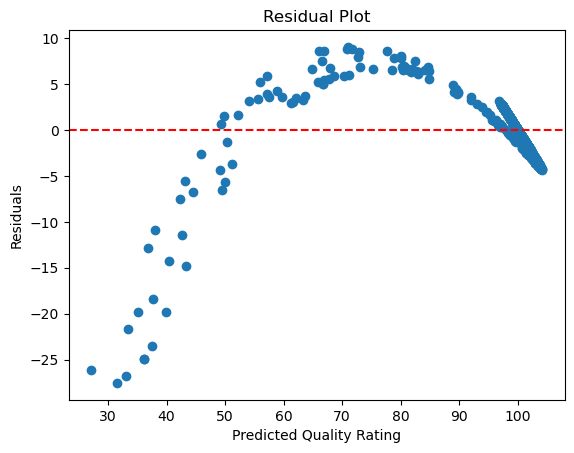

In [140]:
# Step 4: Model Evaluation
# Predictions
plaintext_test_start = time.time()

y_pred = linear_regressor.predict(X_test)
plaintext_test_time = time.time() - plaintext_test_start

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

coeff_memory = linear_regressor.coef_.nbytes
intercept_memory = sys.getsizeof(linear_regressor.intercept_)
features_memory = X_test.nbytes

# Plaintext model performance metrics
print("Performance Metrics (Plaintext model):")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
print()

# Plaintext model runtime
print("Runtime Analysis (Plaintext model):")
preprocessing_total_time = preprocessing_time + feature_selection_time
print(f"Required Preprocessing time: {preprocessing_total_time}")
print(f"Training runtime: {plaintext_train_time:.4f} seconds")
print(f"Evaluation runtime: {plaintext_test_time:.4f} seconds")
plaintext_additional_time = plaintext_test_time + plaintext_train_time
print(f"Total runtime without preprocessing: {plaintext_additional_time:.4f} seconds")
plaintext_total_time = plaintext_test_time + plaintext_train_time + preprocessing_total_time
print(f"Total runtime: {plaintext_total_time:.4f} seconds")
print()

# Plaintext model memory usage
print("Memory Usage (Plaintext model):")
print(f"Memory Usage for Coefficients: {coeff_memory / 1024:.2f} KB")
print(f"Memory Usage for Intercept: {intercept_memory / 1024:.2f} KB")
print(f"Memory Usage for Features: {features_memory / 1024:.2f} KB")

# Residuals histogram
residuals = y_test - y_pred
plt.hist(residuals, bins=20)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Residuals scatterplot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Quality Rating')
plt.ylabel('Residuals')
plt.show()


## Encrypted Inference:

In [141]:
# Step 1: Initialize encryption context
encrypted_context_start = time.time()

context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
# set the scale
context.global_scale = 2 ** 40
# Generate Galois keys for dot product rotations
context.generate_galois_keys()
encrypted_context_time = time.time() - encrypted_context_start


In [142]:
# Step 2: Setup encrypted inferencing
encrypted_encryption_start = time.time()

# Save trained coefficients and intercept
coefficients = linear_regressor.coef_
intercept = linear_regressor.intercept_

# Encrypt coefficients and intercept
encrypted_coefficients = ts.ckks_vector(context, coefficients)
encrypted_intercept = ts.ckks_vector(context, [intercept])

# Step 3: Encrypt inputs
# Encrypt each row of X_test
encrypted_features = [ts.ckks_vector(context, row) for row in X_test]

encrypted_encryption_time = time.time() - encrypted_encryption_start


In [143]:
# Step 4: Perform encrypted inference
encrypted_inference_start = time.time()

encrypted_predictions = []
for enc_row in encrypted_features:
    encrypted_predictions.append(enc_row.dot(encrypted_coefficients) + encrypted_intercept)
    
encrypted_inference_time = time.time() - encrypted_inference_start


Performance Metrics (Encrypted Inference):
Mean Absolute Error: 2.4734990101424974
Mean Squared Error: 15.027682258922189
Root Mean Squared Error: 3.876555463155685
R^2 Score: 0.9263892355412138

Runtime Analysis (Encrypted inference):
Context setup time: 0.4339 seconds
Encryption time: 5.1654 seconds
Encrypted inferencing runtime: 14.2694 seconds
Decryption time: 0.6980 seconds
Additional Overhead Time: 6.2973 seconds
Total runtime without plaintext model and preprocessing: 20.5667 seconds
Total runtime: 24.5216 seconds

Memory Usage (Encrypted inference):
Memory Usage for Encrypted Coefficients: 326.46 KB
Memory Usage for Encrypted Intercept: 229.93 KB
Memory Usage for Encrypted Features: 252.50 MB


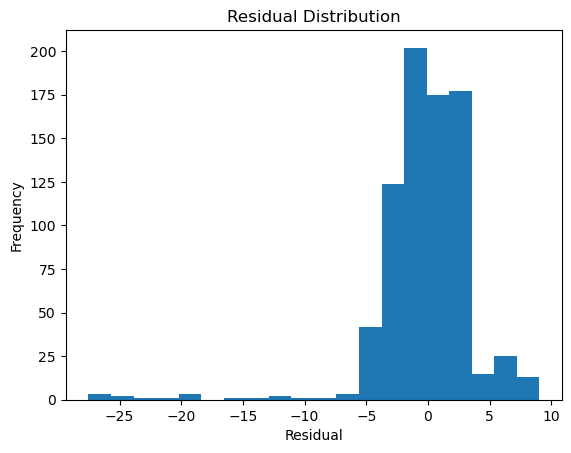

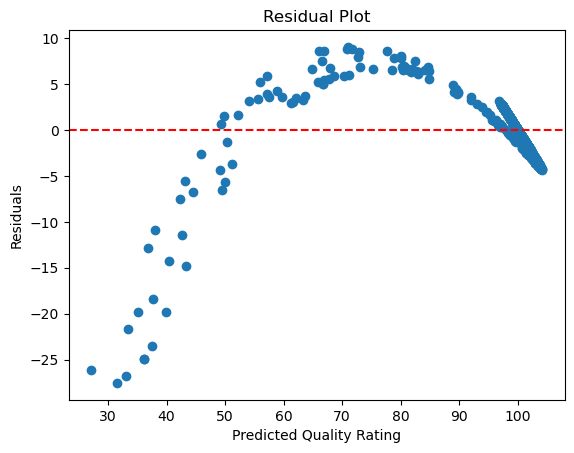

In [144]:
# Step 5: Evaluate Predictions
encrypted_decryption_start = time.time()

# Decrypt predictions
decrypted_predictions = []
for pred in encrypted_predictions:
    decrypted_predictions.append(pred.decrypt())

for idx, val in enumerate(decrypted_predictions):
    decrypted_predictions[idx] = decrypted_predictions[idx][0]
encrypted_decryption_time = time.time()  - encrypted_decryption_start

# Calculate performance metrics
encrypted_mae = mean_absolute_error(y_test, decrypted_predictions)
encrypted_mse = mean_squared_error(y_test, decrypted_predictions)
encrypted_rmse = encrypted_mse ** 0.5
encrypted_r2 = r2_score(y_test, decrypted_predictions)

encrypted_coeff_memory = sys.getsizeof(encrypted_coefficients.serialize())
encrypted_intercept_memory = sys.getsizeof(encrypted_intercept.serialize())
encrypted_features_memory = sum(sys.getsizeof(enc_row.serialize()) for enc_row in encrypted_features)

# Encrypted inference performance metrics
print("Performance Metrics (Encrypted Inference):")
print(f"Mean Absolute Error: {encrypted_mae}")
print(f"Mean Squared Error: {encrypted_mse}")
print(f"Root Mean Squared Error: {encrypted_rmse}")
print(f"R^2 Score: {encrypted_r2}")
print()
# Encrypted inference runtime
print("Runtime Analysis (Encrypted inference):")
print(f"Context setup time: {encrypted_context_time:.4f} seconds")
print(f"Encryption time: {encrypted_encryption_time:.4f} seconds")
print(f"Encrypted inferencing runtime: {encrypted_inference_time:.4f} seconds")
print(f"Decryption time: {encrypted_decryption_time:.4f} seconds")
encrypted_overhead_time = encrypted_decryption_time + encrypted_encryption_time + encrypted_context_time
print(f"Additional Overhead Time: {encrypted_overhead_time:.4f} seconds")
encrypted_additional_time = encrypted_inference_time + encrypted_overhead_time
print(f"Total runtime without plaintext model and preprocessing: {encrypted_additional_time:.4f} seconds")
encrypted_total_time = encrypted_additional_time + plaintext_train_time + preprocessing_total_time
print(f"Total runtime: {encrypted_total_time:.4f} seconds")
print()

# Encrypted inference memory usage
print("Memory Usage (Encrypted inference):")
print(f"Memory Usage for Encrypted Coefficients: {encrypted_coeff_memory / 1024:.2f} KB")
print(f"Memory Usage for Encrypted Intercept: {encrypted_intercept_memory / 1024:.2f} KB")
print(f"Memory Usage for Encrypted Features: {encrypted_features_memory / (1024**2):.2f} MB")

# Residuals histogram
encrypted_residuals = y_test - decrypted_predictions
plt.hist(encrypted_residuals, bins=20)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Residuals scatterplot
plt.scatter(decrypted_predictions, encrypted_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Quality Rating')
plt.ylabel('Residuals')
plt.show()


## Performance Comparison:

Model coefficients:
                                              Feature   Coefficient
5                      Material Transformation Metric -17854.327049
1                                    Temperature (°C)  14042.595457
10    Temperature (°C) Material Transformation Metric   5513.877039
3                              Temperature x Pressure   4701.117549
6                                  Temperature (°C)^2   4363.940246
2                                      Pressure (kPa)  -4350.725523
7                     Temperature (°C) Pressure (kPa)  -2201.599339
20                   Material Transformation Metric^2  -1364.822336
14      Pressure (kPa) Material Transformation Metric   -427.661479
4                              Material Fusion Metric   -321.233369
18                           Material Fusion Metric^2   -201.769455
19  Material Fusion Metric Material Transformation...    201.262954
9             Temperature (°C) Material Fusion Metric    185.071871
13              Pressure (kP

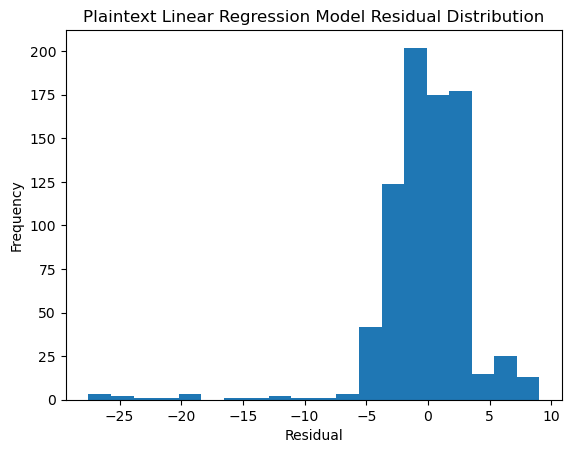

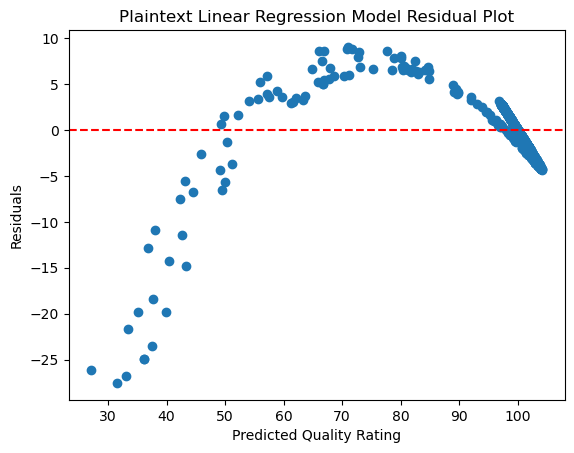

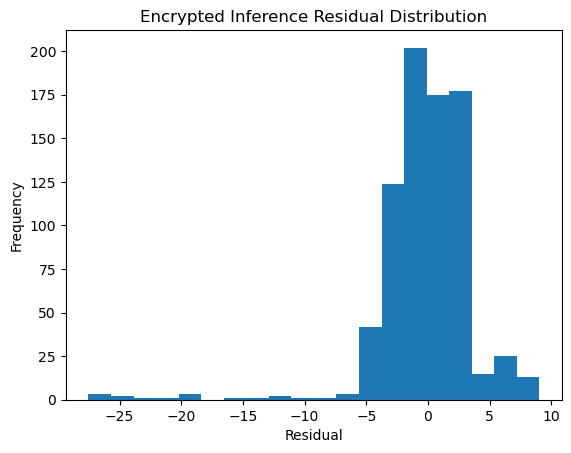

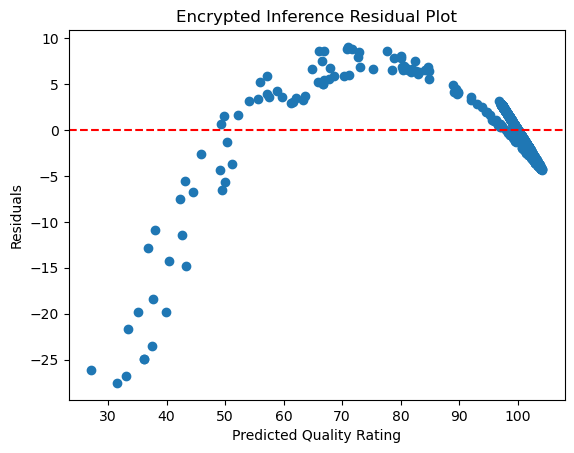

In [145]:
# Compare coefficients to gauge features' impact on Quality Rating

# Plaintext model coefficients
coefficients_df = pd.DataFrame({
    "Feature": X_poly_df.columns,
    "Coefficient": coefficients
})
coefficients_df["Absolute Coefficient"] = coefficients_df["Coefficient"].abs()
coefficients_df = coefficients_df.sort_values(by="Absolute Coefficient", ascending=False)
coefficients_df = coefficients_df.drop(["Absolute Coefficient"], axis=1)

# Encrypted inference coefficients
encrypted_coefficients_df = pd.DataFrame({
    "Feature": X_poly_df.columns,
    "Coefficient": encrypted_coefficients.decrypt()
})
encrypted_coefficients_df["Absolute Coefficient"] = encrypted_coefficients_df["Coefficient"].abs()
encrypted_coefficients_df = encrypted_coefficients_df.sort_values(by="Absolute Coefficient", ascending=False)
encrypted_coefficients_df = encrypted_coefficients_df.drop(["Absolute Coefficient"], axis=1)

print("Model coefficients:")
print(coefficients_df)
print()

print("Decrypted coefficients:")
print(encrypted_coefficients_df)
print()

# Performance Metrics

# Plaintext model performance metrics
print("Performance Metrics (Plaintext model):")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
print()

# Encrypted inference performance metrics
print("Performance Metrics (Encrypted Inference):")
print(f"Mean Absolute Error: {encrypted_mae}")
print(f"Mean Squared Error: {encrypted_mse}")
print(f"Root Mean Squared Error: {encrypted_rmse}")
print(f"R^2 Score: {encrypted_r2}")
print()

# Runtime Analysis

# Plaintext model runtime
print("Runtime Analysis (Plaintext model):")
preprocessing_total_time = preprocessing_time + feature_selection_time
print(f"Required Preprocessing time: {preprocessing_total_time}")
print(f"Training runtime: {plaintext_train_time:.4f} seconds")
print(f"Evaluation runtime: {plaintext_test_time:.4f} seconds")
plaintext_additional_time = plaintext_test_time + plaintext_train_time
print(f"Total runtime without preprocessing: {plaintext_additional_time:.4f} seconds")
plaintext_total_time = plaintext_test_time + plaintext_train_time + preprocessing_total_time
print(f"Total runtime: {plaintext_total_time:.4f} seconds")
print()

# Encrypted inference runtime
print("Runtime Analysis (Encrypted inference):")
print(f"Context setup time: {encrypted_context_time:.4f} seconds")
print(f"Encryption time: {encrypted_encryption_time:.4f} seconds")
print(f"Encrypted inferencing runtime: {encrypted_inference_time:.4f} seconds")
print(f"Decryption time: {encrypted_decryption_time:.4f} seconds")
encrypted_overhead_time = encrypted_decryption_time + encrypted_encryption_time + encrypted_context_time
print(f"Additional Overhead Time: {encrypted_overhead_time:.4f} seconds")
encrypted_additional_time = encrypted_inference_time + encrypted_overhead_time
print(f"Total runtime without plaintext model and preprocessing: {encrypted_additional_time:.4f} seconds")
encrypted_total_time = encrypted_additional_time + plaintext_train_time + preprocessing_total_time
print(f"Total runtime: {encrypted_total_time:.4f} seconds")
print()

# Memory Usage

# Plaintext model memory usage
print("Memory Usage (Plaintext model):")
print(f"Memory Usage for Coefficients: {coeff_memory / 1024:.2f} KB")
print(f"Memory Usage for Intercept: {intercept_memory / 1024:.2f} KB")
print(f"Memory Usage for Features: {features_memory / 1024:.2f} KB")
print()

# Encrypted inference memory usage
print("Memory Usage (Encrypted inference):")
print(f"Memory Usage for Encrypted Coefficients: {encrypted_coeff_memory / 1024:.2f} KB")
print(f"Memory Usage for Encrypted Intercept: {encrypted_intercept_memory / 1024:.2f} KB")
print(f"Memory Usage for Encrypted Features: {encrypted_features_memory / (1024**2):.2f} MB")
print()

# Residuals

# Plaintext model residuals
# Residuals histogram
plt.hist(residuals, bins=20)
plt.title("Plaintext Linear Regression Model Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.savefig("../docs/plaintext_residual_histogram.png")
plt.show()
plt.close()

# Residuals scatterplot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Plaintext Linear Regression Model Residual Plot')
plt.xlabel('Predicted Quality Rating')
plt.ylabel('Residuals')
plt.savefig("../docs/plaintext_residual_scatter.png")
plt.show()
plt.close()

# Encrypted inference residuals
# Residuals histogram
plt.hist(encrypted_residuals, bins=20)
plt.title("Encrypted Inference Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.savefig("../docs/encrypted_residual_histogram.png")
plt.show()
plt.close()

# Residuals scatterplot
plt.scatter(decrypted_predictions, encrypted_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Encrypted Inference Residual Plot')
plt.xlabel('Predicted Quality Rating')
plt.ylabel('Residuals')
plt.savefig("../docs/encrypted_residual_scatter.png")
plt.show()
plt.close()


## Data Export

In [ ]:
# Merge the two DataFrames on the "Feature" column
combined_coefficients_df = pd.merge(
    coefficients_df,
    encrypted_coefficients_df,
    on="Feature",
    suffixes=("_Plaintext", "_Encrypted")
)

# Rename columns for clarity
combined_coefficients_df.rename(columns={
    "Coefficient_Plaintext": "Plaintext Coefficient",
    "Coefficient_Encrypted": "Encrypted Coefficient"
}, inplace=True)

data_to_export = {
    "Coefficients": combined_coefficients_df,
}

# Create a performance metrics DataFrame
performance_metrics = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R²"],
    "Plaintext Model": [mae, mse, rmse, r2],
    "Encrypted Inference": [encrypted_mae, encrypted_mse, encrypted_rmse, encrypted_r2],
})

data_to_export["Performance Metrics"] = performance_metrics

runtime_data = pd.DataFrame({
    "Step": [
        "Context Setup Time",
        "Preprocessing Time",
        "Training Time",
        "Encryption Time",
        "Decryption Time",
        "Evaluation Time",
        "Additional Overhead Time",
        "Total Without Initial Preprocessing",
        "Total Runtime",
    ],
    "Plaintext Model": [
        None,  # Context setup doesn't apply to plaintext
        preprocessing_total_time,
        plaintext_train_time,
        None, # No encryption for plaintext
        None, # No decryption for plaintext
        plaintext_test_time,
        None, # Already accounted for preprocessing
        plaintext_additional_time,
        plaintext_total_time,
    ],
    "Encrypted Inference": [
        encrypted_context_time,
        preprocessing_total_time, # Same preprocessing as plaintext
        plaintext_train_time, # Training taken from plaintext model
        encrypted_encryption_time,
        encrypted_decryption_time,
        encrypted_inference_time,
        encrypted_overhead_time,
        encrypted_additional_time,
        encrypted_total_time,
    ],
})
data_to_export["Runtime Analysis"] = runtime_data

memory_usage_data = pd.DataFrame({
    "Type": ["Coefficients", "Intercept", "Features"],
    "Plaintext Model (KB)": [coeff_memory / 1024, intercept_memory / 1024, features_memory / 1024],
    "Encrypted Inference (KB)": [
        encrypted_coeff_memory / 1024,
        encrypted_intercept_memory / 1024,
        encrypted_features_memory / 1024,  # Convert MB back to KB for consistency
    ],
})
data_to_export["Memory Usage"] = memory_usage_data

# Write data to Excel file
with pd.ExcelWriter("../docs/Analyses.xlsx") as writer:
    for sheet_name, df in data_to_export.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Data exported to ../docs/Analyses.xlsx")


Data exported to ../docs/Analyses.xlsx
